In [1]:
import os, h5py
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing

from track import SOLAR_LOGG, SOLAR_TEFF, SOLAR_ZX

print('tensorflow ==', tf.__version__)

%matplotlib inline

tensorflow == 2.3.2


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
path = 'data/yrec_grid.h5'
h5f = h5py.File(path, 'r')

dset = h5f['data']
data = np.array(dset)
columns = dset.attrs['columns']

h5f.close()

In [4]:
df = pd.DataFrame(data, columns=columns)
del data

In [5]:
df.head()

,EEP,M/Msun,Age(Gyr),[Fe/H],fk,Rocrit,Prot(days),log(Teff)(K),R/Rsun,log(Z/X)(surface)
0,1.000000,1.06,0.036089,0.1,6.0,2.75,0.374777,3.752937,0.987328,-1.692670
1,1.045365,1.06,0.037402,0.1,6.0,2.75,0.383608,3.751863,0.979282,-1.692682
2,1.067487,1.06,0.039110,0.1,6.0,2.75,0.395994,3.751114,0.975430,-1.692698
3,1.069806,1.06,0.041330,0.1,6.0,2.75,0.412794,3.750794,0.975226,-1.692721
4,1.079711,1.06,0.044216,0.1,6.0,2.75,0.435389,3.750821,0.976990,-1.692753


In [6]:
mask = df['Prot(days)'] == 0
df.drop(df.loc[mask].index, inplace=True)

In [7]:
df['log(R/Rsun)'] = np.log10(df['R/Rsun'])
df['log(g)'] = SOLAR_LOGG + np.log10(df['M/Msun']) - 2 * df['log(R/Rsun)']
df['log(L/Lsun)'] = 2 * df['log(R/Rsun)'] + 4 * (df['log(Teff)(K)'] - np.log10(SOLAR_TEFF))
df['[Fe/H](surface)'] = df['log(Z/X)(surface)'] - np.log10(SOLAR_ZX)

In [8]:
df['log(Prot)(days)'] = np.log10(df['Prot(days)'])

In [9]:
df['log(Age)(Gyr)'] = np.log10(df['Age(Gyr)'])

In [10]:
# non_diff = df.loc[df['EEP'] == 1, '[Fe/H](surface)'].to_numpy() == df.loc[df['EEP'] == 2, '[Fe/H](surface)'].to_numpy()
# np.sum(non_diff)

In [11]:
# start = df.loc[df['EEP'] == 1, '[Fe/H](surface)'].index.to_numpy()
# stop = df.loc[df['EEP'] == 3, '[Fe/H](surface)'].index.to_numpy()

In [12]:
# non_diff_idx = np.concatenate([np.arange(st, sp+1, dtype=int) for st, sp in zip(start[non_diff], stop[non_diff])])

In [13]:
# len(non_diff_idx) / len(df)

In [14]:
# len(df) - len(non_diff_idx)

In [15]:
# df.drop(non_diff_idx, inplace=True)

In [16]:
# len(df)

In [20]:
random_state = 2

train = df.sample(frac=0.8, random_state=random_state)
test = df.drop(train.index)

In [21]:
print('Train length = ', len(train))
print('Test length = ', len(test))

Train length =  38447873
Test length =  9611968


In [22]:
del df

In [17]:
input_cols = ['EEP', 'M/Msun', '[Fe/H]', 'fk', 'Rocrit']
output_cols = ['log(Age)(Gyr)', 'log(Prot)(days)']

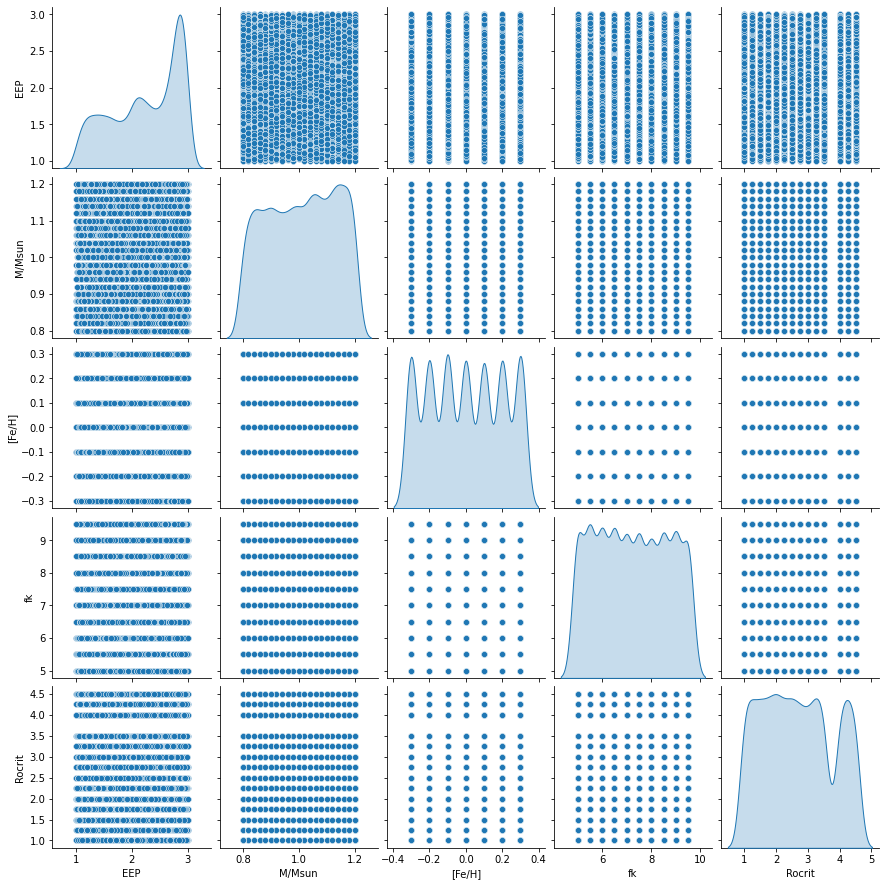

In [18]:
sns.pairplot(train[input_cols].sample(10000), diag_kind='kde');

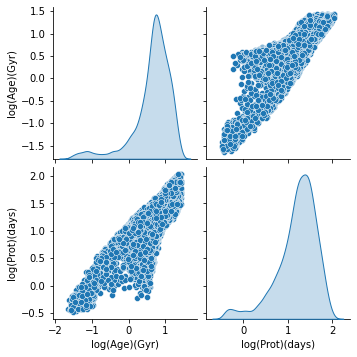

In [85]:
sns.pairplot(train[output_cols].sample(10000), diag_kind='kde');

In [23]:
input_normalizer = preprocessing.Normalization()
input_normalizer.adapt(train[input_cols].to_numpy())

In [24]:
input_mean = input_normalizer.mean.numpy()
input_var = input_normalizer.variance.numpy()
for col, mean, var in zip(input_cols, input_mean, input_var):
    print(f'{col:<15}: {mean:.3e}, {var:.3e}')

EEP            : 2.220e+00, 3.686e-01
M/Msun         : 1.008e+00, 1.474e-02
[Fe/H]         : -2.550e-03, 3.995e-02
fk             : 7.250e+00, 2.062e+00
Rocrit         : 2.679e+00, 1.173e+00


In [25]:
output_normalizer = preprocessing.Normalization()
output_normalizer.adapt(train[output_cols].to_numpy())

In [26]:
output_mean = output_normalizer.mean.numpy()
output_var = output_normalizer.variance.numpy()
for col, mean, var in zip(output_cols, output_mean, output_var):
    print(f'{col:<15}: {mean:.3e}, {var:.3e}')

log(Age)(Gyr)  : 6.385e-01, 2.842e-01
log(Prot)(days): 1.195e+00, 2.106e-01


In [27]:
output_rescaler = preprocessing.Rescaling(scale=np.sqrt(output_var), 
                                          offset=output_mean)

In [28]:
def build_model(n_neurons, n_hidden, activation='elu', l2_reg=0.0):
    reg = regularizers.L2(l2_reg)
    hidden_layers = [layers.Dense(n_neurons, 
                                  activation=activation, 
                                  kernel_regularizer=reg) for layer in range(n_hidden)]
    all_layers = [input_normalizer] + hidden_layers + [layers.Dense(len(output_cols)), output_rescaler]
    model = keras.Sequential(all_layers)
    return model

In [53]:
model = build_model(128, 10, l2_reg=0.0)

In [54]:
model.save('data/models/test_model')

INFO:tensorflow:Assets written to: data/models/test_model/assets


In [55]:
learning_rate = 1e-4
momentum = 0.999

model.compile(loss='mean_squared_error',
#              optimizer=keras.optimizers.SGD(learning_rate, momentum=momentum),
             optimizer=keras.optimizers.Adam(learning_rate)
             )

In [56]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 5)                 11        
_________________________________________________________________
dense_25 (Dense)             (None, 128)               768       
_________________________________________________________________
dense_26 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_27 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_28 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_29 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_30 (Dense)             (None, 128)              

In [57]:
batch_size = 8192*2

print('Number of batches:', len(train)//batch_size)
print('Remainder:', len(train)%batch_size)

Number of batches: 2346
Remainder: 11009


In [71]:
%%time
history = model.fit(
    train[input_cols], train[output_cols],
    validation_split=0.2,
    batch_size=batch_size,
    verbose=0, epochs=500,
)

CPU times: user 3h 20min 22s, sys: 18min 4s, total: 3h 38min 27s
Wall time: 1h 29min 11s


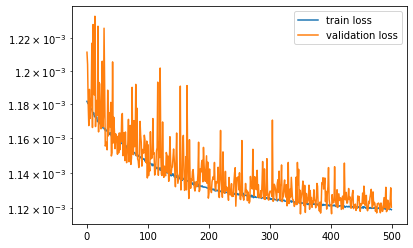

In [72]:
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train loss')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='validation loss')

plt.yscale('log')
plt.legend()

In [73]:
model.save('data/models/test_model')

INFO:tensorflow:Assets written to: data/models/test_model/assets


In [74]:
pred = pd.DataFrame(model(test[input_cols]).numpy(), columns=output_cols)
pred.head()

,log(Age)(Gyr),log(Prot)(days)
0,-1.451281,-0.423909
1,-0.899211,0.232803
2,-0.831538,0.329869
3,-0.232901,0.821493
4,-0.091780,0.903362


In [75]:
truth = test[output_cols].reset_index(drop=True)
error = truth - pred
frac_error = (truth - pred) / truth

In [76]:
truth.head()

,log(Age)(Gyr),log(Prot)(days)
0,-1.442631,-0.426228
1,-1.035855,0.025122
2,-0.957876,0.175681
3,-0.277206,0.800040
4,-0.121034,0.890828


In [77]:
log_cols = ['log(Age)(Gyr)', 'log(Prot)(days)']

for col in log_cols:
    error[f'10^{col}'] = 10**truth[col] - 10**pred[col]
    frac_error[f'10^{col}'] = (10**truth[col] - 10**pred[col]) / 10**truth[col]

In [78]:
error.head()

,log(Age)(Gyr),log(Prot)(days),10^log(Age)(Gyr),10^log(Prot)(days)
0,0.008650,-0.002319,0.000712,-0.002007
1,-0.136644,-0.207681,-0.034046,-0.649687
2,-0.126337,-0.154188,-0.037202,-0.638734
3,-0.044305,-0.021453,-0.056729,-0.319532
4,-0.029254,-0.012534,-0.052732,-0.227725


In [79]:
error.mean()

log(Age)(Gyr)         0.000814
log(Prot)(days)      -0.000920
10^log(Age)(Gyr)      0.006184
10^log(Prot)(days)   -0.036132
dtype: float64

In [80]:
error.std()

log(Age)(Gyr)         0.022746
log(Prot)(days)       0.041442
10^log(Age)(Gyr)      0.069802
10^log(Prot)(days)    1.328694
dtype: float64

In [81]:
frac_error.mean()

log(Age)(Gyr)         0.012656
log(Prot)(days)      -0.002505
10^log(Age)(Gyr)      0.000509
10^log(Prot)(days)   -0.006777
dtype: float64

In [82]:
frac_error.std()

log(Age)(Gyr)          6.277514
log(Prot)(days)       13.260264
10^log(Age)(Gyr)       0.054586
10^log(Prot)(days)     0.100444
dtype: float64

In [86]:
from scipy import stats

In [87]:
stats.median_abs_deviation(error)

array([0.00243311, 0.01484703, 0.02808824, 0.56845194])

In [88]:
stats.median_abs_deviation(frac_error)

array([0.00311049, 0.01139178, 0.00559309, 0.03413609])

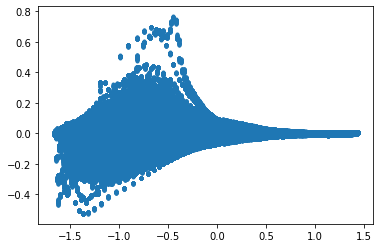

In [90]:
plt.plot(truth['log(Age)(Gyr)'], error['log(Age)(Gyr)'], '.');

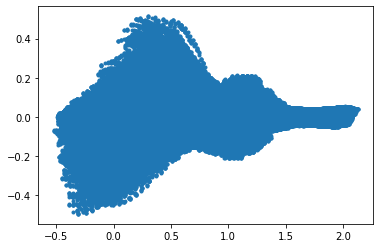

In [91]:
plt.plot(truth['log(Prot)(days)'], error['log(Prot)(days)'], '.');

In [89]:
truth.head()

,log(Age)(Gyr),log(Prot)(days)
0,-1.442631,-0.426228
1,-1.035855,0.025122
2,-0.957876,0.175681
3,-0.277206,0.800040
4,-0.121034,0.890828
